# Draw fNIRS topographic maps

Draw fNIRS topographic maps using the extracted feature (HbT-DE) from the REFED dataset.

Input: Extracted features folder `REFED-dataset/features/`.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from load_REFED import load_feature
import pickle as pkl
import mne
import gc
import pandas as pd

In [2]:
path_data = './REFED-dataset/features'
info_fNIRS_path = "./ch_info_fNIRS.pkl"

In [3]:
# Load fNIRS features
data_fNIRS = load_feature(path_data, modality=['fNIRS'])

with open(info_fNIRS_path, 'rb') as f:
    fNIRS_pos, channels = pkl.load(f)

In [4]:
# Average fNIRS features over time for each video and subject
avg_fNIRS = [] # to store average fNIRS data
for si in data_fNIRS.keys():
    avg_fNIRS.append([])
    for vi in range(1, 16):
        avg_fNIRS[-1].append(data_fNIRS[si]['fNIRS']['v%d'%vi].mean((0)))
avg_fNIRS = np.array(avg_fNIRS)
print(avg_fNIRS.shape)

# Video indices for each emotion
video_emotion = [
    [0,9,11], # MVMA, Neutral
    [3,6,14], # HVHA, Happy
    [2,8,10], # LVHA, Angry/Fear
    [1,5,12], # LVLA, Sad
    [4,7,13]  # HVLA, Relaxed
] 
emotion_labels = ['MVMA', 'HVHA', 'LVHA', 'LVLA', 'HVLA']

# Compute average fNIRS features for each emotion category
fNIRS_emotion = [avg_fNIRS[:,video_emotion[ei],:].mean((0,1)) for ei in range(5)]

# Compute overall average fNIRS features across all emotions
all_avg = np.stack(fNIRS_emotion).mean((0))

(32, 15, 51, 6)


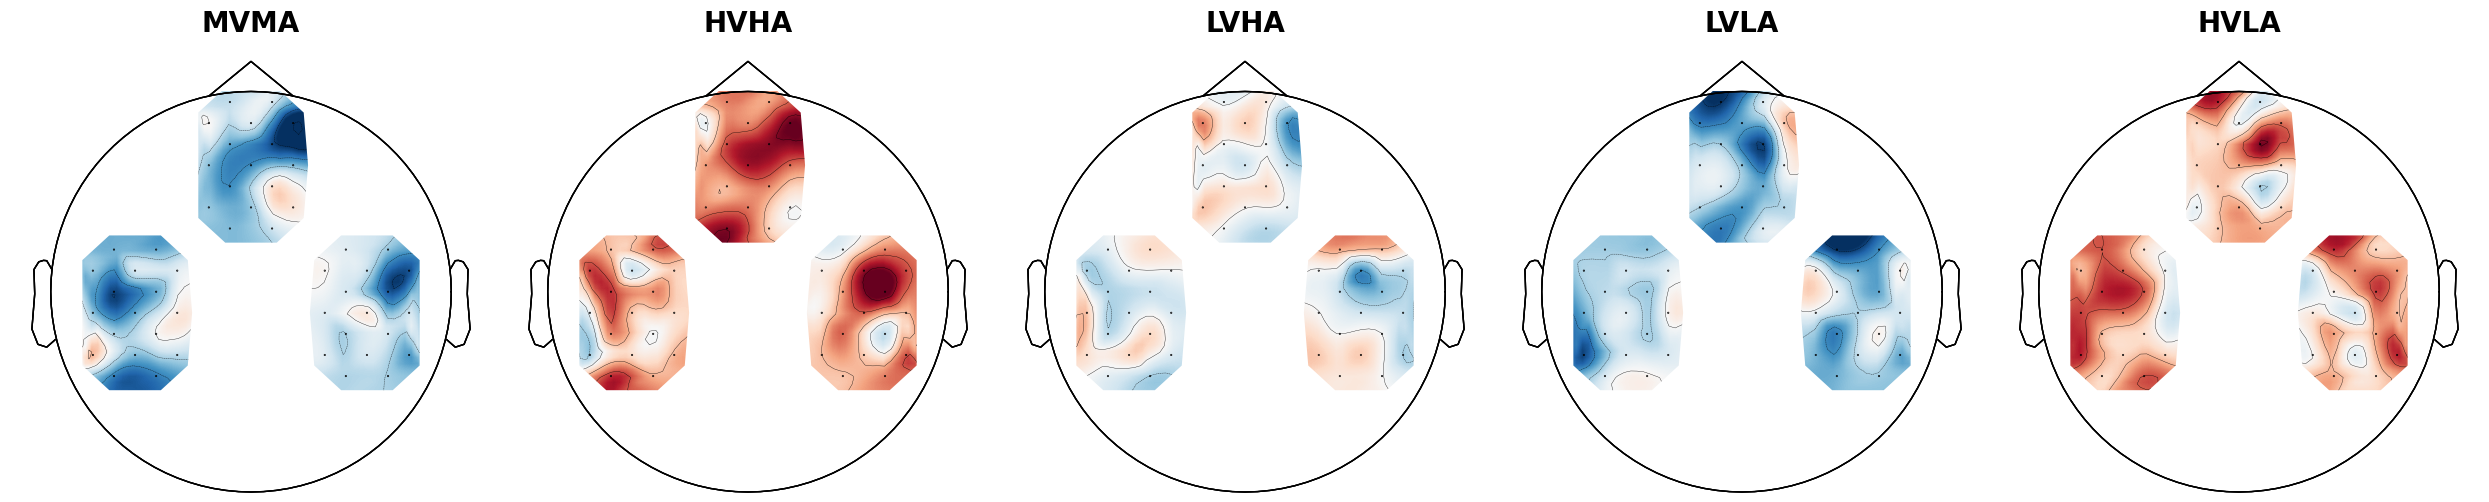

In [5]:
# Create MNE montage for fNIRS channels
montage = mne.channels.make_dig_montage(ch_pos=fNIRS_pos, coord_frame='head')
channels = list(fNIRS_pos.keys())

# Plot topographic maps for each emotion
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25,5))
for i in range(0,5):
    data_video = np.expand_dims(fNIRS_emotion[i].mean(1) - all_avg.mean(1), 1)

    # Create MNE Evoked object
    info = mne.create_info(ch_names=channels, sfreq=1, ch_types='eeg')
    raw = mne.EvokedArray(data_video, info)
    raw.set_montage(montage)
    
    # Plot topomap in three regions
    raw.copy().pick(picks=range(0, 17)).plot_topomap(axes=axes[i], show=False, colorbar=False, extrapolate='local', vlim=(-8e4, 8e4))
    raw.copy().pick(picks=range(17, 34)).plot_topomap(axes=axes[i], show=False, colorbar=False, extrapolate='local', vlim=(-8e4, 8e4))
    raw.copy().pick(picks=range(34, 51)).plot_topomap(axes=axes[i], show=False, colorbar=False, extrapolate='local', vlim=(-8e4, 8e4))

    # Set title for each subplot
    axes[i].set_title(emotion_labels[i], fontsize=20, fontweight='bold')

plt.tight_layout()
# plt.savefig('topo_EEG.png', dpi=300)
plt.show()